In [ ]:
# Utilities
import os
import math
import numpy as np
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns
sns.set()
%matplotlib inline
set_matplotlib_formats("svg", "pdf")

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import torchvision.io as io
import torchmetrics
from torchmetrics.classification import Accuracy, F1Score, Recall, Precision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, ModelSummary

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_float32_matmul_precision("high")
print(f"Running on {device}")

# Data pre-processing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import feature_extraction, linear_model, model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold

# NLP
import re
import nltk
import emoji

nltk.download("wordnet")
nltk.download("stopwords")

# Data inspection

## Location
More than 50% of the values in this column are missing. Additionally, many locations are not actual locations (ex. *THEY/THEM or HE/HIM*, *The internet or the gym*, *Great State of Texas*).

Replacing NaN's and highly infrequent ($<2$ appearances) bogus locations with the most common value (*United States*) results in an extremely disproportionate dataset, thus I decided not to include location in the input.

In [5]:
df = pd.read_csv("data/tweets.csv")
most_frequent = df["location"].mode()[0]
df["location"] = df["location"].fillna(most_frequent)

counts = df["location"].value_counts()
df["location"] = df["location"].replace(to_replace=counts[counts < 3].index, value=most_frequent)
df["location"].value_counts()

location
United States       8006
Australia             83
London, England       81
UK                    77
India                 74
                    ... 
Oregon                 3
Rajasthan, India       3
Ukraine                3
Norwich, UK            3
US                     3
Name: count, Length: 424, dtype: int64

## Keywords
These may actually prove to be useful in the classification task. I'll encode them using OHE.

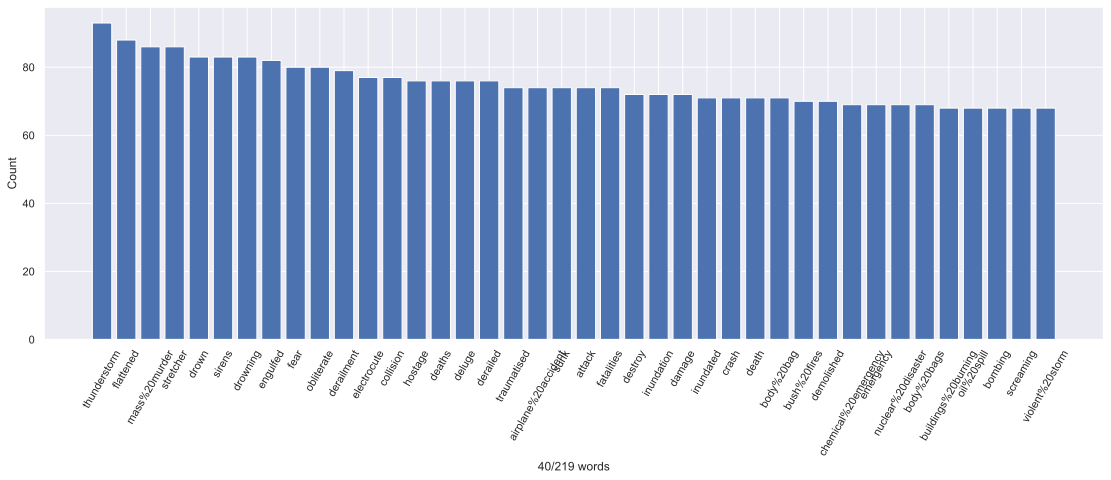

In [6]:
df = pd.read_csv("data/tweets.csv")
counts = df["keyword"].value_counts()

fig, ax = plt.subplots(1, 1, figsize=(19.0, 6.0))
ax.bar(counts[:40].index, counts[:40].values)
ax.tick_params(axis='x', labelrotation=60)
plt.xlabel(f"40/{len(counts)} words")
plt.ylabel("Count")
plt.show()

# Dataset
The tweets are encoded using TFIDF. Pre-vectorization processing consists of:
- tweet tokenization (strips handles, lowercases everything, cuts constant sequences to length 3)
- links are replaced with a `<LINK>` token
- punctuation is removed
- emojis are demojized
- stopwords are removed
- remaining tokens are lemmatized using Wordnet

The keywords and labels are encoded using one-hot encoding.

In [7]:
class DisasterTweets(data.Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        vectorizer = TfidfVectorizer(
            min_df=0.001,
            stop_words = None,
            tokenizer = DisasterTweets._process_tweet,
            token_pattern = None
        )

        encoder = OneHotEncoder(sparse_output=False)
        
        path = os.path.join(root, "tweets.csv")
        self.df = pd.read_csv(path)

        keywords = encoder.fit_transform(self.df[["keyword"]])
        texts = vectorizer.fit_transform(self.df["text"]).todense()

        self.data = torch.from_numpy(np.concatenate((keywords, texts), axis=1)).float()
        self.label = F.one_hot(torch.from_numpy(self.df["target"].to_numpy()), num_classes=2).float()
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        data, label = self.data[idx], self.label[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

    def class_weights(self):
        return compute_class_weight("balanced", classes=np.unique(self.df["target"].to_numpy()), y=self.df["target"].to_numpy())

    @classmethod
    def _process_tweet(self, tweet):
        url_pattern = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
    
        tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
        lemmatizer = nltk.stem.WordNetLemmatizer()
        stopwords = nltk.corpus.stopwords.words("english")

        tokens = []
        for word in tokenizer.tokenize(tweet):
            if re.match(url_pattern, word) is not None:
                tokens.append("<LINK>")
                continue

            if emoji.is_emoji(word):
                tokens.append(emoji.demojize(word))
                continue
            
            if word in stopwords or not word.isalnum():
                continue
            
            tokens.append(lemmatizer.lemmatize(word))

        return tokens

# Model
Braindead linear model with 5 layers using ReLU activation, BCE loss and StepLR scheduling (every 50 epochs with $\gamma = 0.1$).

In [8]:
class TweetClassifier(pl.LightningModule):
    def __init__(self, input_size, class_weights=None, lr=0.001):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
        )

        self.save_hyperparameters()

        self.lr = lr
        self.class_weights = class_weights
        self.criterion = nn.BCEWithLogitsLoss(weight=self.class_weights)

        self.validation_metrics = torchmetrics.MetricCollection([
            Accuracy(task="binary"),
            F1Score(task="binary"),
            Precision(task="binary"),
            Recall(task="binary"),
        ], prefix="validation_")

        self.test_metrics = torchmetrics.MetricCollection([
            Accuracy(task="binary"),
            F1Score(task="binary"),
            Precision(task="binary"),
            Recall(task="binary"),
        ], prefix="test_")

    def forward(self, x):
        return self.layers(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, i):
        x, y = batch
        yhat = self.layers(x)
        
        loss = self.criterion(yhat, y)
        self.log("train_Loss", loss)

        return loss

    def validation_step(self, batch, i):
        x, y = batch
        yhat = self.layers(x)

        preds, truth = yhat.argmax(dim=-1), y.argmax(dim=-1)
        self.validation_metrics.update(preds, truth)
        self.log_dict(self.validation_metrics, on_step=False, on_epoch=True)

    def test_step(self, batch, i):
        x, y = batch
        yhat = self.layers(x)

        preds, truth = yhat.argmax(dim=-1), y.argmax(dim=-1)
        self.test_metrics.update(preds, truth)
        self.log_dict(self.test_metrics, on_step=False, on_epoch=True)

# Training

In [9]:
def train(model_class, train_loader, val_loader, **kwargs):
    trainer = pl.Trainer(
        default_root_dir = "logs",
        accelerator = "gpu" if str(device).startswith("cuda") else "cpu",
        devices = 1,
        max_epochs = 150,
        callbacks = [
            LearningRateMonitor(),
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="validation_BinaryF1Score"),
            ModelSummary(max_depth=-1),
        ],
        enable_progress_bar = True
    )
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None

    input_size = next(iter(train_loader))[0].shape[1]

    model = model_class(input_size, **kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = model_class.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

def test(model, loader):
    trainer = pl.Trainer(
        default_root_dir = "logs",
        accelerator = "gpu" if str(device).startswith("cuda") else "cpu",
        devices = 1,
        max_epochs = 50,
        enable_progress_bar = True
    )
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None

    trainer.test(model, loader)

In [10]:
full_set = DisasterTweets(root="./data")
train_set, val_set, test_set = data.random_split(full_set, [len(full_set) - 3000, 2000, 1000])

print(f"Word vec dimensions: {full_set[0][0].shape}")
print(f"Class weights: {full_set.class_weights()}")

train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=False, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

Word vec dimensions: torch.Size([1964])
Class weights: [0.6141962  2.68921476]


In [ ]:
model = train(TweetClassifier, train_loader, val_loader)

# Results and testing

In [13]:
test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_BinaryAccuracy      0.8709999918937683
   test_BinaryF1Score       0.6700767278671265
  test_BinaryPrecision       0.668367326259613
    test_BinaryRecall       0.6717948913574219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


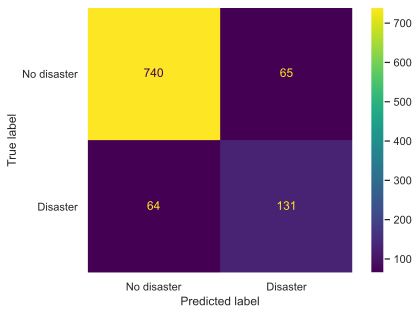

In [14]:
with torch.no_grad():
    model = model.to(device)
    model.eval()
    ground, preds = torch.empty(0).to(device), torch.empty(0).to(device)
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        p = model(x).argmax(dim=-1)
        y = y.argmax(-1)
    
        ground = torch.cat((ground, y), 0)
        preds = torch.cat((preds, p), 0)

    ground, preds = ground.cpu().numpy(), preds.cpu().numpy()
    conf_matrix = ConfusionMatrixDisplay.from_predictions(ground, preds, display_labels=["No disaster", "Disaster"])
    plt.grid(False)